In [3]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table , join
from mocpy import MOC
from astropy.io import fits
from astropy import wcs



This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. The prior for XID+ is based on IRAC detected sources coming from SWIRE.

In [9]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_AKARI-NEP/data/holes_AKARI-NEP_O16_MOC.fits')
filename='../../dmu18/dmu18_HELP-PACS-maps/data/AKARI-NEP_PACS100_v0.9.fits'
hdulist = fits.open(filename)
im100phdu=hdulist['IMAGE'].header
akari_moc=MOC.from_image(im100phdu,13, ~np.isnan(hdulist['IMAGE'].data))
akari_moc.write('./data/akari-nep_moc.fits')



im_moc=pymoc.MOC()
im_moc.read('./data/akari-nep_moc.fits')

Final=Sel_func.intersection(im_moc)


In [10]:
Final.write('./data/testMoc.fits', overwrite=True)
#Final=pymoc.MOC()
#Final.read('./data/testMoc.fits')

## Read in XID+MIPS catalogue

In [11]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_AKARI-NEP/data/output/dmu26_XID+MIPS_AKARI-NEP_cat_20190227.fits')

In [12]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J180701.864+662041.204,271.757767221287,66.3447789421774,90.63546,241.97984,22.712053,3.1406586,4.970802e-06,0.99907345,2000.0,0.513,True
HELP_J175704.238+661840.010,269.267657371287,66.3111139621774,49.71215,128.79857,12.516103,2.9815512,5.136997e-06,nan,2000.0,0.023,False
HELP_J175711.539+661917.722,269.29807791498104,66.321589402738,25.949755,52.407436,8.08266,2.9815512,5.136997e-06,0.9993326,2000.0,0.0,True
HELP_J175708.522+661904.863,269.285510191287,66.3180175621774,31.772854,68.475685,8.703482,2.9815512,5.136997e-06,1.0005753,2000.0,0.142,False
HELP_J175648.306+661921.139,269.201273401287,66.3225385621774,38.59976,96.733185,10.378979,2.9671657,5.012875e-06,1.0028639,1531.0,0.001,False
HELP_J175650.628+661917.875,269.210949911287,66.3216319721774,112.779854,187.42662,43.069798,2.9671657,5.012875e-06,1.0001805,1324.0,0.001,False
HELP_J175658.470+661951.154,269.243625281287,66.3308762021774,24.30152,51.78544,6.697779,2.9903955,4.864628e-06,nan,2000.0,0.035,True
HELP_J175709.207+661927.379,269.288360861287,66.32427196217739,15.047924,34.47429,4.4338813,2.9903955,4.864628e-06,1.0004203,2000.0,0.0,True


2.7453837
0


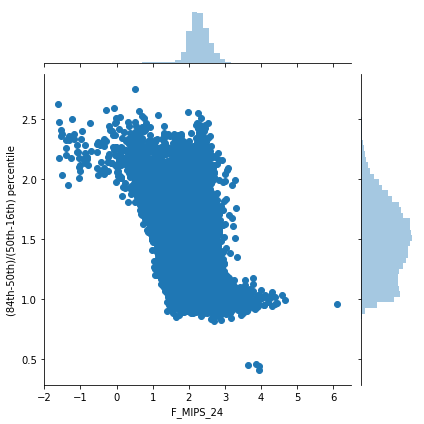

In [16]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='scatter')
print(np.max(skew[use]))
print(len(skew[n_use]))


The uncertianties become Gaussian by $\sim 30 \mathrm{\mu Jy}$

In [17]:
good=XID_MIPS['F_MIPS_24']>30

In [18]:
good.sum()

35319

## Read in Maps

In [19]:
im100fits='../../dmu18/dmu18_HELP-PACS-maps/data/AKARI-NEP_PACS100_v0.9.fits'#PACS 100 map
im160fits='../../dmu18/dmu18_HELP-PACS-maps/data/AKARI-NEP_PACS160_v0.9.fits'#PACS 160 map

#output folder
output_folder='./'

In [20]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im100hdu=hdulist['IMAGE'].header

w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im160hdu=hdulist['IMAGE'].header

w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist.close()

In [21]:
np.shape(im100)

(1622, 1605)

## Read in PSF

In [24]:
pacs100_psf=fits.open('../../dmu18/dmu18_AKARI-NEP/data/dmu18_PACS_100_PSF_AKARI-NEP_20190125.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_AKARI-NEP/data/dmu18_PACS_160_PSF_AKARI-NEP_20190125.fits')

print (pacs100_psf)
centre100=np.long((pacs100_psf[0].header['NAXIS1']-1)/2)
radius100=10
centre160=np.long((pacs160_psf[0].header['NAXIS1']-1)/2)
radius160=10

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[0].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[0].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map




In [25]:
print(pind160)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


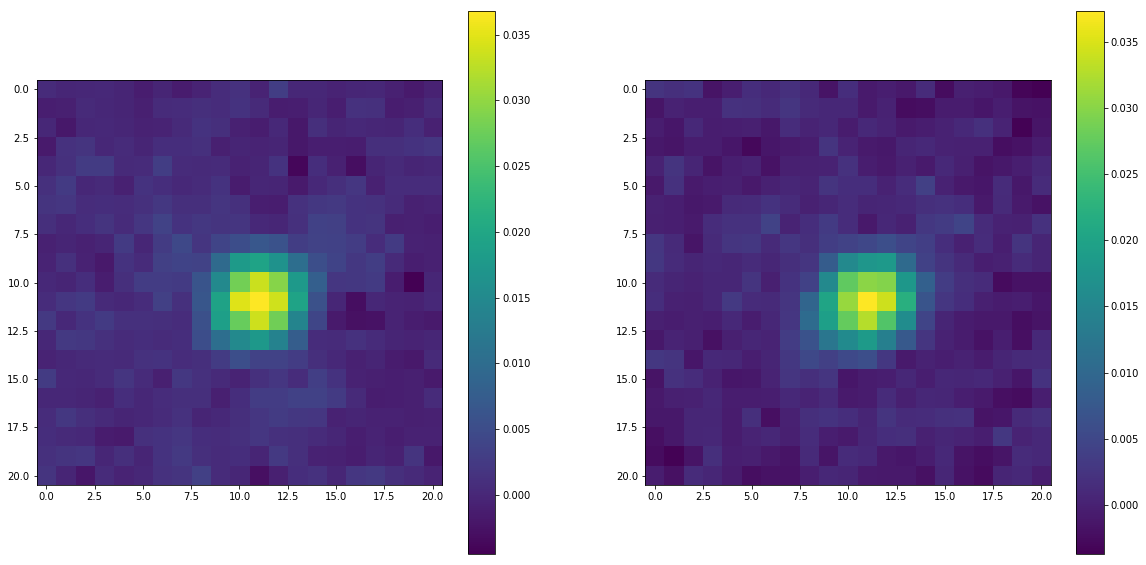

In [27]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[0].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()


## Set XID+ prior class

In [28]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_AKARI-NEP_cat_20190227.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Final)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_AKARI-NEP_cat_20190227.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [29]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[0].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [30]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 732 tiles required for input catalogue and 3 large tiles


SystemExit: 